In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [3]:
## 读取数据
path1 = "datas/winequality-red.csv"
df1 = pd.read_csv(path1, sep=";")
df1['type'] = 1 # 设置数据类型为红葡萄酒

path2 = "datas/winequality-white.csv"
df2 = pd.read_csv(path2, sep=";")
df2['type'] = 2 # 设置数据类型为白葡萄酒

# 合并两个df
df = pd.concat([df1,df2], axis=0)

## 自变量名称
names = ["fixed acidity","volatile acidity","citric acid",
         "residual sugar","chlorides","free sulfur dioxide",
         "total sulfur dioxide","density","pH","sulphates",
         "alcohol", "type"]
## 因变量名称
quality = "quality"

## 显示
df.head(5)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [26]:
## 异常数据处理
new_df = df.replace('?', np.nan)
datas = new_df.dropna(how = 'any') # 只要有行为空，就进行删除操作
print ("原始数据条数:%d；异常数据处理后数据条数:%d；异常数据条数:%d" % (len(df), len(datas), len(df) - len(datas)))

## 提取自变量和因变量
X = datas[names]
Y = datas[quality]

原始数据条数:6497；异常数据处理后数据条数:6497；异常数据条数:0


In [27]:
## 数据分割
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

print ("训练数据条数:%d；数据特征个数:%d；测试数据条数:%d" % (X_train.shape[0], X_train.shape[1], X_test.shape[0]))

训练数据条数:4872；数据特征个数:12；测试数据条数:1625


In [28]:
# 2. 数据格式化(归一化)
# 将数据缩放到[0,1]
ss = MinMaxScaler()
X_train = ss.fit_transform(X_train) ## 训练模型及归一化数据

In [29]:
## 查看y值的范围和数理
Y_train.value_counts()

6    2132
5    1606
7     805
4     161
8     146
3      20
9       2
Name: quality, dtype: int64

In [38]:
# 3. 模型构建及训练
## penalty: 过拟合解决参数,l1或者l2

## solver: 参数优化方式
### 当penalty为l1的时候，参数只能是：liblinear(坐标轴下降法)；
### 当penalty为l2的时候，参数可以是：lbfgs(拟牛顿法)、newton-cg(牛顿法变种)

## multi_class: 分类方式参数；参数可选: ovr(默认)、multinomial；这两种方式在二元分类问题中，效果是一样的；在多元分类问题中，效果不一样
### ovr: one-vs-rest， 对于多元分类的问题，先将其看做二元分类，分类完成后，再迭代对其中一类继续进行二元分类
### multinomial: many-vs-many（MVM）,对于多元分类问题，如果模型有T类，我们每次在所有的T类样本里面选择两类样本出来，
#### 不妨记为T1类和T2类，把所有的输出为T1和T2的样本放在一起，把T1作为正例，T2作为负例，
#### 进行二元逻辑回归，得到模型参数。我们一共需要T(T-1)/2次分类

## class_weight: 特征权重参数

### Softmax算法相对于Logistic算法来讲，在sklearn中体现的代码形式来讲，主要只是参数的不同而已
## Logistic算法回归(二分类): 使用的是ovr；如果是softmax回归，建议使用multinomial
lr = LogisticRegressionCV(fit_intercept=True, Cs=np.logspace(-5, 1, 100), 
                          multi_class='multinomial', penalty='l2', solver='lbfgs')
lr.fit(X_train, Y_train)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


LogisticRegressionCV(Cs=array([  1.00000e-05,   1.14976e-05, ...,   8.69749e+00,   1.00000e+01]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [39]:
# 4. 模型效果获取
r = lr.score(X_train, Y_train)
print("准确率：", r)
print("特征稀疏化比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print("参数：",lr.coef_)
print("截距：",lr.intercept_)
print("概率：", lr.predict_proba(X_test)) # 获取softmax函数返回的概率值

准确率： 0.549876847291
特征稀疏化比率：0.00%
参数： [[ 0.97829778  2.17040546 -0.41910318 -0.49429808  0.90606748  1.44850231
   0.7569874   0.2303342   0.00765436 -0.69782044 -0.71862088 -0.29184835]
 [ 0.62522538  5.12268551 -0.37876432 -2.1605937   1.21557221 -3.72669545
  -1.4597162   1.34183936  0.34182741 -0.8674164  -2.74823593  2.03280138]
 [-1.73911246  1.95783456  0.48734411 -1.91305259  0.64352295 -1.67968046
   2.20420134  1.49410538 -1.36330712 -2.23648963 -5.0127851  -0.756792  ]
 [-1.19942231 -2.608935   -0.34627165  0.17054802 -0.04261719  0.81418148
  -0.28239311  0.51920873 -0.6794754   0.18380316  0.01775102 -0.71447893]
 [ 1.15674624 -4.66326549 -0.3097966   2.21462812 -2.00739731  1.67073352
  -1.03080859 -2.15488489  0.80568534  2.68450646  3.36183456 -0.73695466]
 [-0.07758276 -1.83550625  0.69531125  2.08092125 -0.62532642  1.49751589
  -0.15857277 -1.36695091  0.72830855  1.07355955  4.69287965  0.04642119]
 [ 0.25584813 -0.14321878  0.27128038  0.10184698 -0.08982172 -0.024

In [10]:
print("概率：", lr.predict_proba(X_test).shape) # 获取softmax函数返回的概率值

概率： (1625, 7)


In [32]:
# 数据预测
## a. 预测数据格式化(归一化)
X_test = ss.transform(X_test) # 使用模型进行归一化操作
## b. 结果数据预测
Y_predict = lr.predict(X_test)

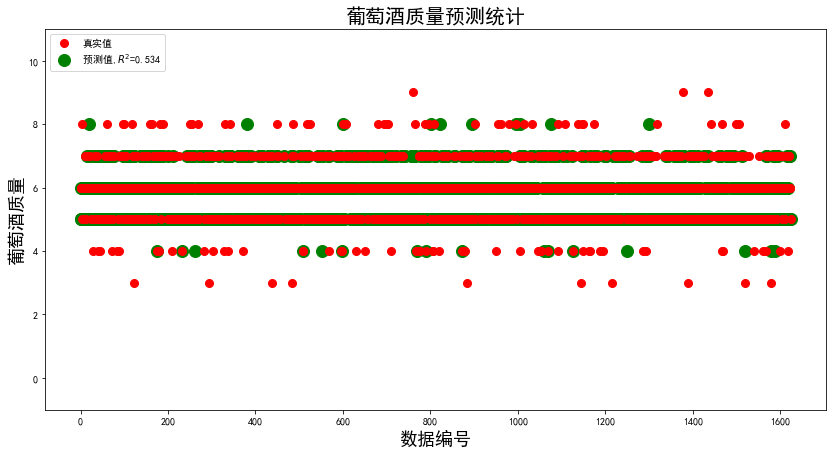

In [33]:
## c. 图表展示
x_len = range(len(X_test))
plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(-1,11)
plt.plot(x_len, Y_test, 'ro',markersize = 8, zorder=3, label=u'真实值')
plt.plot(x_len, Y_predict, 'go', markersize = 12, zorder=2, label=u'预测值,$R^2$=%.3f' % lr.score(X_train, Y_train))
plt.legend(loc = 'upper left')
plt.xlabel(u'数据编号', fontsize=18)
plt.ylabel(u'葡萄酒质量', fontsize=18)
plt.title(u'葡萄酒质量预测统计', fontsize=20)
plt.show()